# Проект прогнозирования снижения покупательской активности для интернет-магазина "В один клик"

# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

Задачи:
1. Промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
3. Включить в исследование дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
4. Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

Исследование включает в себя 9 разделов:
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод

In [1]:
pip install scikit-learn==1.1.3 shap phik seaborn==0.13.1 

     |████████████████████████████████| 30.8 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 533 kB 89.0 MB/s eta 0:00:01
     |████████████████████████████████| 686 kB 87.1 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 91.6 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 58.8 MB/s eta 0:00:01
     |████████████████████████████████| 310 kB 98.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 98.7 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
Note: you 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import phik
from phik.report import plot_correlation_matrix
from phik import phik_matrix
import shap

## Загрузка данных 

В данном разделе были загружены и описаны датасеты датасеты.

Датасет `customers_info` содержит информацию о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Ниже представлено превью данных.
Датасет имеет следующие данные:
- id — номер покупателя в корпоративной базе данных  
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт»  
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель  
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [3]:
customers_info = pd.read_csv('market_file.csv')
print(f'Число записей: {len(customers_info)}')
customers_info.head()

Число записей: 1300


id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

Датасет `money_info` содержит информацию о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Ниже представлено превью данных.
Датасет имеет следующие данные:
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

In [4]:
money_info = pd.read_csv('/datasets/market_money.csv')
print(f'Число записей: {len(customers_info)}')
money_info.head()

Число записей: 1300


id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

Датасет `time_info` содержит информацию о времени (в минутах), которое покупатель провёл на сайте в течение периода. Ниже представлено превью данных.
Датасет имеет следующие данные:
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

In [5]:
time_info = pd.read_csv('/datasets/market_time.csv') 
print(f'Число записей: {len(time_info)}')
time_info.head()

Число записей: 2600


id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

Датасет `profits_info` содержит информацию о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Ниже представлено превью данных.
Датасет имеет следующие данные:
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

In [6]:
profits_info = pd.read_csv('/datasets/money.csv', sep = ';', decimal=',') 
print(f'Число записей: {len(profits_info)}')
profits_info.head()

Число записей: 1300


id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

**ВЫВОД**  

В данном разделе были загружены и описаны 4 датасета для дальнейшей работы.

## Предобработка данных

В данном разделе была проведена предобработка данных: отформатированы наименования параметров, исправлены некорректные значения а также преведены к единому формату таблицы.

Датасет `customers_info` содержит 1300 записей, не имеет пропусков. Формат данных в порядке.

In [7]:
customers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Для единого формата, часть наименований была отформатирована. При анализе значений категориальных данных были зафиксированы некорректные значения, т.е. опечатки, и были исправлены. 

In [8]:
print('Прежние значения:')
for col in customers_info.select_dtypes('object'):
    print(f'{col}: {customers_info[col].unique()}')
customers_info.loc[customers_info['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'
customers_info.columns = customers_info.columns.str.replace(' ', '_')
customers_info.loc[customers_info['Популярная_категория'] == 'Косметика и аксесуары', 'Популярная_категория'] = 'Косметика и аксессуары'

Прежние значения:
Покупательская активность: ['Снизилась' 'Прежний уровень']
Тип сервиса: ['премиум' 'стандартт' 'стандарт']
Разрешить сообщать: ['да' 'нет']
Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [9]:
print('Новые значения:')
for col in customers_info.select_dtypes('object'):
    print(f'{col}: {customers_info[col].unique()}')

Новые значения:
Покупательская_активность: ['Снизилась' 'Прежний уровень']
Тип_сервиса: ['премиум' 'стандарт']
Разрешить_сообщать: ['да' 'нет']
Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


При проверки на дубликаты, оные не были найдены.

In [10]:
print(f'Количество строк-дубликатов: {customers_info.duplicated().sum()}')
print(f'Количество пользователей-дубликатов: {customers_info["id"].duplicated().sum()}')

Количество строк-дубликатов: 0
Количество пользователей-дубликатов: 0


Датасет `customers_info` содержит 3900 записей, не имеет пропусков. Формат данных в порядке.

In [11]:
money_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Всего данные представлены за 3 периода:'препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'.

In [12]:
money_info['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Датасет был преобразован к новому формату: каждый период выделен в отдельный столбец. В результате изменений, датасет имеет 1300 строк, без пропусков. Ниже представлено превью измененного датасета.

In [13]:
money_info = pd.pivot_table(
    data = money_info, 
    index = 'id', 
    columns = 'Период', 
    values = 'Выручка', 
    aggfunc = 'sum') \
    .reset_index() \
    .rename_axis(None, axis=1) \
    .rename(columns = {'препредыдущий_месяц':'выручка_препредыдущий_месяц', 'предыдущий_месяц':'выручка_предыдущий_месяц', 'текущий_месяц':'выручка_текущий_месяц'})
print(money_info.info())
money_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1300 non-null   int64  
 1   выручка_предыдущий_месяц     1300 non-null   float64
 2   выручка_препредыдущий_месяц  1300 non-null   float64
 3   выручка_текущий_месяц        1300 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 40.8 KB
None


id  выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
0  215348                       0.0                          0.0   
1  215349                    5216.0                       4472.0   
2  215350                    5457.5                       4826.0   
3  215351                    6158.0                       4793.0   
4  215352                    5807.5                       4594.0   

   выручка_текущий_месяц  
0                 3293.1  
1                 4971.6  
2                 5058.4  
3                 6610.4  
4                 5872.5

При проверки на дубликаты, оные не были найдены.

In [14]:
print(f'Количество строк-дубликатов: {money_info.duplicated().sum()}')
print(f'Количество пользователей-дубликатов: {money_info["id"].duplicated().sum()}')

Количество строк-дубликатов: 0
Количество пользователей-дубликатов: 0


Датасет `time_info` содержит 2600 записей, не имеет пропусков. Формат данных в порядке.

In [15]:
time_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Всего данные представлены за 2 периода: 'текущий_месяц', 'предыдущий_месяц'.

In [16]:
time_info['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Датасет был преобразован к новому формату: каждый период выделен в отдельный столбец. В результате изменений, датасет имеет 1300 строк, без пропусков. Ниже представлено превью измененного датасета.

In [17]:
time_info = pd.pivot_table(
    data = time_info, 
    index = 'id', 
    columns = 'Период', 
    values = 'минут', 
    aggfunc = 'sum') \
    .reset_index() \
    .rename_axis(None, axis=1) \
    .rename(columns = {'предыдцщий_месяц':'минут_предыдущий_месяц', 'текущий_месяц':'минут_текущий_месяц'})
print(time_info.info())
time_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   id                      1300 non-null   int64
 1   минут_предыдущий_месяц  1300 non-null   int64
 2   минут_текущий_месяц     1300 non-null   int64
dtypes: int64(3)
memory usage: 30.6 KB
None


id  минут_предыдущий_месяц  минут_текущий_месяц
0  215348                      13                   14
1  215349                      12                   10
2  215350                       8                   13
3  215351                      11                   13
4  215352                       8                   11

При проверки на дубликаты, оные не были найдены.

In [18]:
print(f'Количество строк-дубликатов: {time_info.duplicated().sum()}')
print(f'Количество пользователей-дубликатов: {time_info["id"].duplicated().sum()}')

Количество строк-дубликатов: 0
Количество пользователей-дубликатов: 0


Датасет `profits_info` содержит 1300 записей, не имеет пропусков. Формат данных в порядке.

In [19]:
profits_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


При проверки на дубликаты, оные не были найдены.

In [20]:
print(f'Количество строк-дубликатов: {profits_info.duplicated().sum()}')
print(f'Количество пользователей-дубликатов: {profits_info["id"].duplicated().sum()}')

Количество строк-дубликатов: 0
Количество пользователей-дубликатов: 0


**ВЫВОД**  

В данном разделе была проведена предобработка данных: исправлены некорректные наименования, трансформированы таблицы к единому формату, проведена проверка на дубликаты, пропуски и корректность формата данных.

## Исследовательский анализ данных

В данном разделе был проведен исследовательский анализ данных.

1300 пользователей совершали хотя бы 1 покупки за 3 месяца. 1297 польхователей совершали покупки в каждый из 3 месяцев. 

In [21]:
len(money_info[
    (money_info['выручка_препредыдущий_месяц'] + \
     money_info['выручка_предыдущий_месяц'] + \
     money_info['выручка_текущий_месяц']) > 0])

1300

In [22]:
len(money_info[
    (money_info['выручка_препредыдущий_месяц'] != 0) & \
    (money_info['выручка_предыдущий_месяц'] != 0) & \
    (money_info['выручка_текущий_месяц']!= 0)])

1297

In [23]:
money_info = money_info[
    (money_info['выручка_препредыдущий_месяц'] != 0) & \
    (money_info['выручка_предыдущий_месяц'] != 0) & \
    (money_info['выручка_текущий_месяц']!= 0)]

Из датасета money_info были исключены пользователи, не совершившие минимум 1 покупки хотя бы в 1 из 3 месяцев.

In [24]:
customers_info.describe().T

count           mean         std  \
id                                   1300.0  215997.500000  375.421985   
Маркет_актив_6_мес                   1300.0       4.253769    1.014814   
Маркет_актив_тек_мес                 1300.0       4.011538    0.696868   
Длительность                         1300.0     601.898462  249.856289   
Акционные_покупки                    1300.0       0.319808    0.249843   
Средний_просмотр_категорий_за_визит  1300.0       3.270000    1.355350   
Неоплаченные_продукты_штук_квартал   1300.0       2.840000    1.971451   
Ошибка_сервиса                       1300.0       4.185385    1.955298   
Страниц_за_визит                     1300.0       8.176923    3.978126   

                                          min        25%        50%  \
id                                   215348.0  215672.75  215997.50   
Маркет_актив_6_мес                        0.9       3.70       4.20   
Маркет_актив_тек_мес                      3.0       4.00       4.00   
Длительность                            110.0     405.50     606.00   
Акционные_покупки                         0.0       0.17       0.24   
Средний_просмотр_категорий_за_визит       1.0       2.00       3.00   
Неоплаченные_продукты_штук_квартал        0.0       1.00       3.00   
Ошибка_сервиса                            0.0       3.00       4.00   
Страниц_за_визит                          1.0       5.00       8.00   

                                           75%        max  
id                                   216322.25  216647.00  
Маркет_актив_6_мес                        4.90       6.60  
Маркет_актив_тек_мес                      4.00       5.00  
Длительность                            806.00    1079.00  
Акционные_покупки                         0.30       0.99  
Средний_просмотр_категорий_за_визит       4.00       6.00  
Неоплаченные_продукты_штук_квартал        4.00      10.00  
Ошибка_сервиса                            6.00       9.00  
Страниц_за_визит                         11.00      20.00

Ниже представлено распределение вышеуказанных параметров.

In [25]:
def show_scaling(df, column):
    
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,6))
    fig.suptitle(f'Параметр: {column}', fontsize=15)

    
    sns.set_theme(style="darkgrid")
    
    sns.histplot(df, x=column, hue="Покупательская_активность", shrink=1, alpha=.5, legend=True, ax=axes[0])
    axes[0].set_title('Гистограмма распределения')

    sns.boxplot(y=df[column], hue = df['Покупательская_активность'], ax=axes[1], fill=False, gap=.1)
    axes[1].set_title('Разброс значений признаков')
    axes[1].legend(loc=1)
    
    sns.violinplot(y=df[column], hue = df['Покупательская_активность'], split=True, ax=axes[2], fill=False, inner="quart")
    axes[2].set_title('Разброс значений признаков')
    
    plt.show()

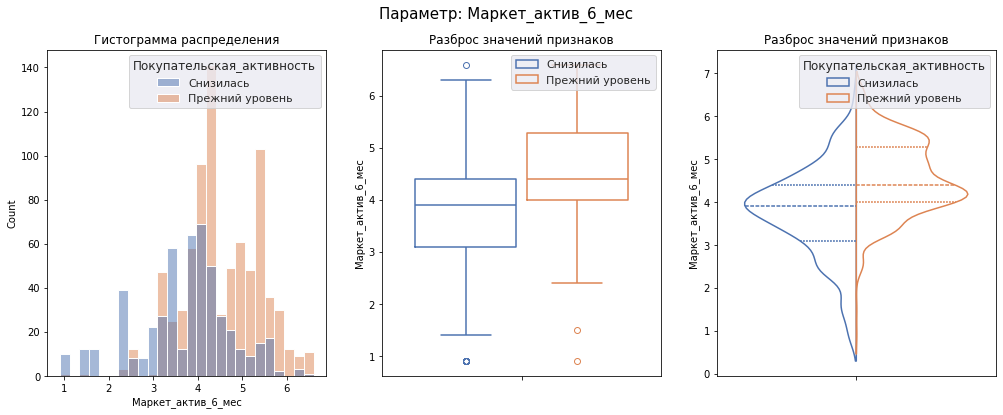

In [26]:
show_scaling(customers_info, 'Маркет_актив_6_мес')

Медианное среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев составляет 4.2 при минимальном 0.9 и максимальном 6.6. Для клиентов со сниженным уровнем активности значение признака ниже, а распределение близкое к нормальному. Распределение покупателей со с прежнем уровнем активности - бимодальное. Присутствуют выбросы, но в пределах реальных значений. Значение параметра выше для клиентов с прежним уровнем активности.

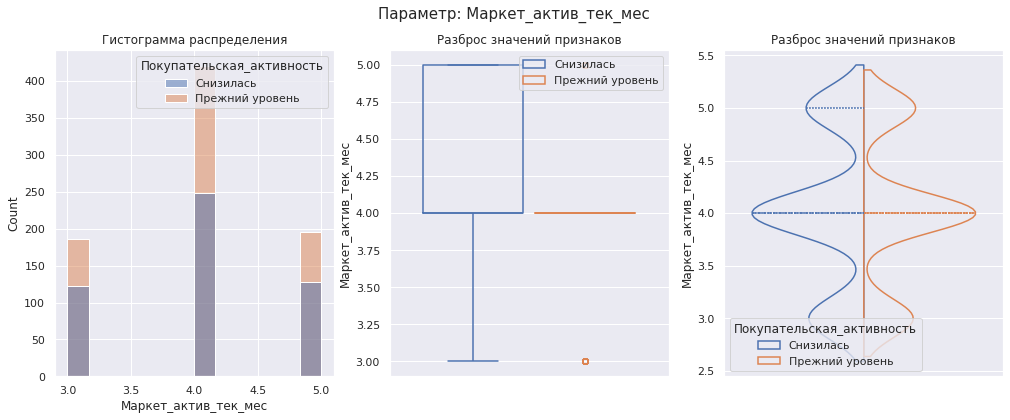

In [27]:
show_scaling(customers_info, 'Маркет_актив_тек_мес')

Медианное количество маркетинговых коммуникаций в текущем месяце составляет 4 при минимальном 3 и максимальном 5. На покупателей с прежнем уровнем активности реже приходилось 5 коммуникаций за текущий в месяц. Статистические выбросы в пределах реальных значений.

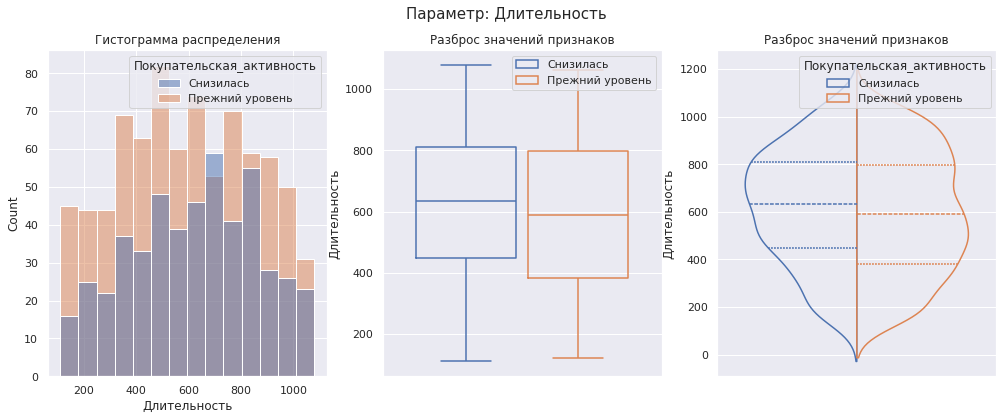

In [28]:
show_scaling(customers_info, 'Длительность')

Медианное значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте, составляет 606 при минимальном 110 и максимальном 1079. Распеределение близкое к нормальному. Параметр в пределах допустимых значений.

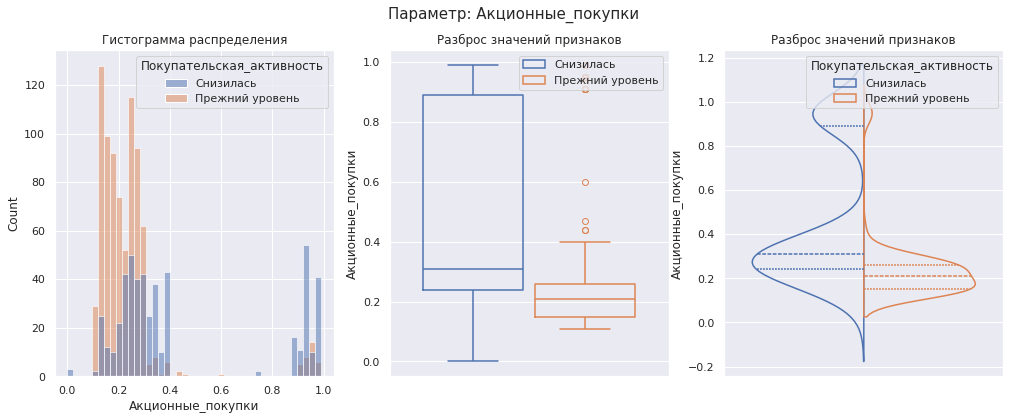

In [29]:
show_scaling(customers_info, 'Акционные_покупки')

Медианная среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев составляет 0.24 при минимальном 0 и максимальном 0.99. Параметр распределен по 2 категориям: кто часто покупает акционные товары и те,чья доля составляет менее 0.5. Бимодальное распределение для клиентов со сниженной активностью - они чаще покупают товары по акции. Выбросы для категории клиентов с прежним уровнем активности в пределах реальных значений.

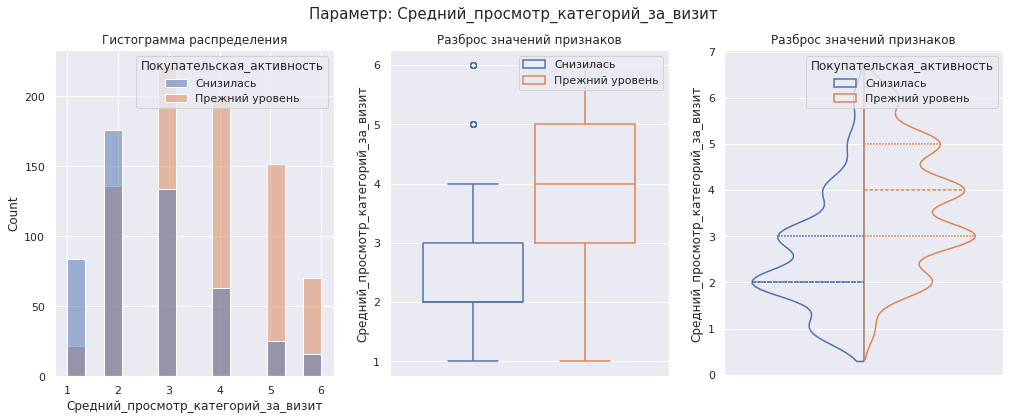

In [30]:
show_scaling(customers_info, 'Средний_просмотр_категорий_за_визит')

Медианное число просмотренных категорий за визит в течение последнего месяца составляет 3 при минимальном 1 и максимальном 6. Распределение правостороннее для категории покупателей со сниженной активностью и мультимодальное - для клиентов с прежнем уровнем активности. Значение параметра выше для клиентов с прежней покупательской активностью

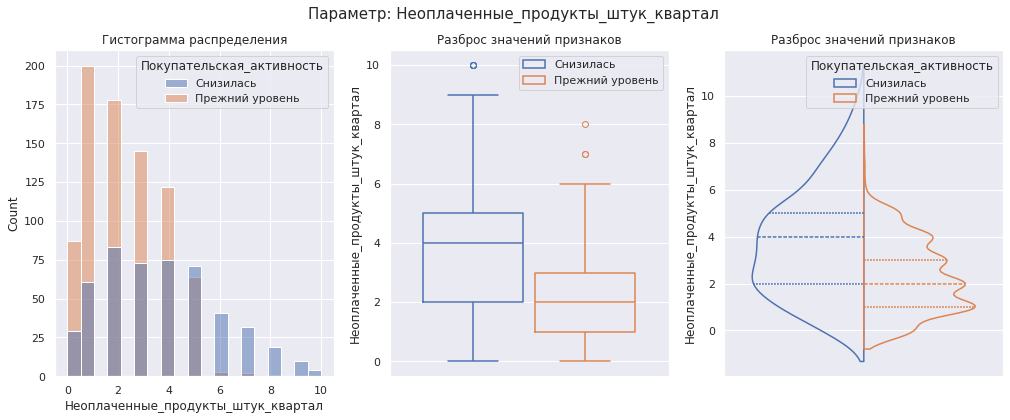

In [31]:
show_scaling(customers_info, 'Неоплаченные_продукты_штук_квартал')

Медианное общее число неоплаченных товаров в корзине за последние 3 месяца составляет 3 при минимальном 0 и максимальном 10. Распределение правостороннее. Значение параметра выше для категории покупателей со сниженной активностью. Есть несколько выбросов у обоих категорий клиентов, но в пределах реальных значений.

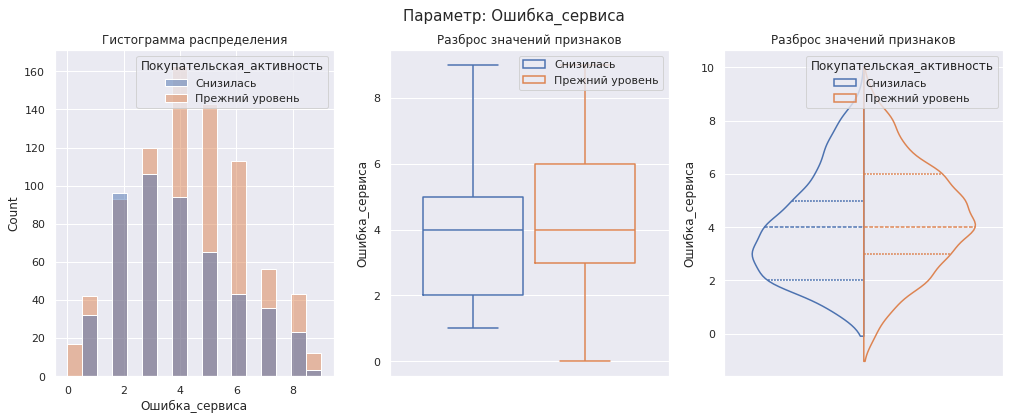

In [32]:
show_scaling(customers_info, 'Ошибка_сервиса')

Медианное число сбоев, которые коснулись покупателя во время посещения сайта, составляет 4 при минимальном 0  и максимальном 9. Распределение нормальное для клиентов с прежней покупательской активностью и правостороннее - для клиентов со сниженной активностью. Параметр в пределах допустимых значений.

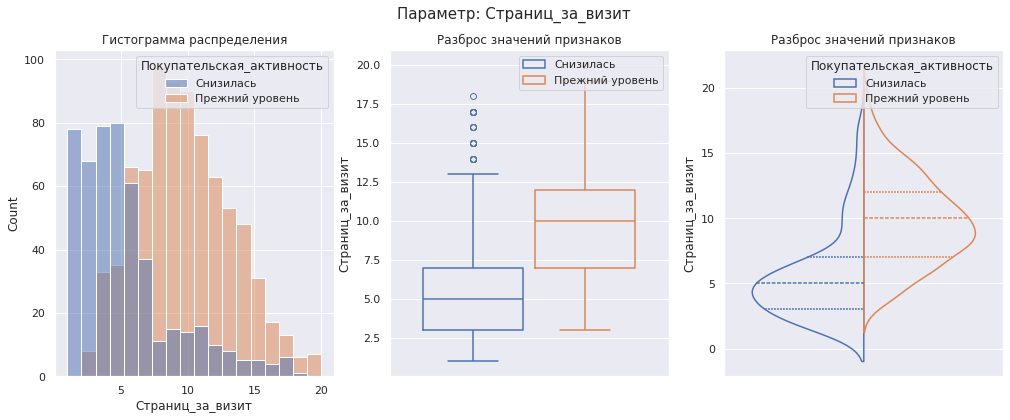

In [33]:
show_scaling(customers_info, 'Страниц_за_визит')

Медианное среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, составляет 8 при минимальном 1 и максимальном 20. Распределение правостороннее. Значение параметра выше для категории покупателей с прежней активностью. Есть несколько выбросов для клиентов со сниженной активностью, но в пределах реальных значений.

Распределение указанных категориальных признаков представлено ниже: 

In [34]:
def get_pie_charts(df):
    df_object = df.select_dtypes('object')
    fig, ax = plt.subplots(nrows=1, ncols=len(df_object.columns), figsize=(16,10))
    i = 0
    for col in df_object.columns:
        ax[i].pie(x=df_object[col].value_counts().sort_values(), 
                  autopct='%1.1f%%') 
        ax[i].set_title(col)
        ax[i].legend(labels = df_object[col].value_counts().sort_values().index, loc="upper center", bbox_to_anchor=(0.5, 0))
        i += 1

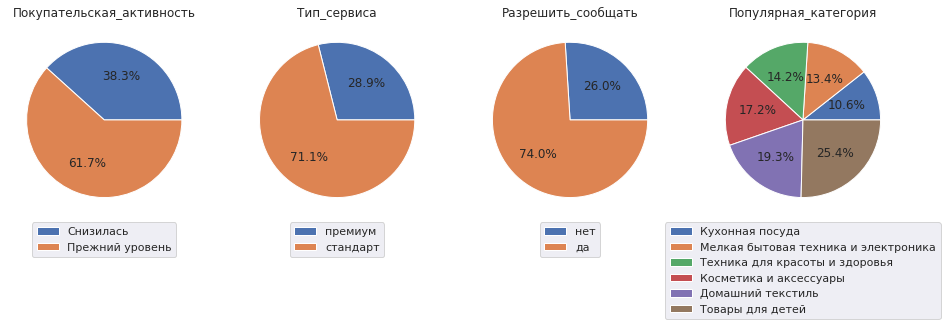

In [35]:
get_pie_charts(customers_info)

- 61.7% пользователей имеют класс покупательской активности "Прежний уровень", у 38.3% активность снизилась.
- 71.1% пользователей имею стандартный тип сервиса, и 28.9% - премиум.
- 74% разрешили присылать предложения, 26% - отказались.
- Товары для детей - самая популярная категория для 25.4%. Далее идут: домашний текстиль, косметика и аксессуары, техника для красоты и здоровья, мелкая бытовая техника и электроника, кухонная посуда.

Распределение в соответствии с выручкой представлено ниже.

In [36]:
money_info.describe()

id  выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
count    1297.000000               1297.000000                  1297.000000   
mean   215998.986893               4948.339630                  4836.367772   
std       374.578554                701.228571                   333.438742   
min    215349.000000               2890.000000                  4098.000000   
25%    215675.000000               4498.500000                  4585.000000   
50%    215999.000000               5005.500000                  4812.000000   
75%    216323.000000               5409.000000                  5055.000000   
max    216647.000000               6869.500000                  5663.000000   

       выручка_текущий_месяц  
count            1297.000000  
mean             5316.449268  
std              2942.469139  
min              2758.700000  
25%              4706.600000  
50%              5180.300000  
75%              5761.300000  
max            106862.200000

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
i = 0
for col in money_info.columns[1:].tolist():
    ax[i].hist(x=money_info[col], bins=30)
    ax[i].set_title(col)
    i += 1

- Медианное значение выручки в препредыдущем месяце составляет 4809 при минимальном 0 и максимальном 5663. Распределение правостороннее близкое к нормальному.
- Медианное значение выручки в предыдущем месяце составляет 5005 при минимальном 0 и максимальном 6869. Распределение левостороннее.
- Медианное значение выручки в текущем месяце составляет 5179 при минимальном 2758.7 и максимальном 106862.

Данные выглядят реалистично за исключением слишком высокого значения в текущем месяце.

Наблюдение с высоким значением выручки в текущем месяце было удалено. Новое распределение представлено ниже. Распределение нормальное.

In [38]:
money_info.describe()

id  выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
count    1297.000000               1297.000000                  1297.000000   
mean   215998.986893               4948.339630                  4836.367772   
std       374.578554                701.228571                   333.438742   
min    215349.000000               2890.000000                  4098.000000   
25%    215675.000000               4498.500000                  4585.000000   
50%    215999.000000               5005.500000                  4812.000000   
75%    216323.000000               5409.000000                  5055.000000   
max    216647.000000               6869.500000                  5663.000000   

       выручка_текущий_месяц  
count            1297.000000  
mean             5316.449268  
std              2942.469139  
min              2758.700000  
25%              4706.600000  
50%              5180.300000  
75%              5761.300000  
max            106862.200000

In [39]:
ids_to_drop = money_info.loc[money_info['выручка_текущий_месяц'] > 20000, 'id'].values.tolist()
money_info = money_info.loc[~money_info['id'].isin(ids_to_drop)]
customers_info = customers_info.loc[~customers_info['id'].isin(ids_to_drop)]
time_info = time_info.loc[~time_info['id'].isin(ids_to_drop)]

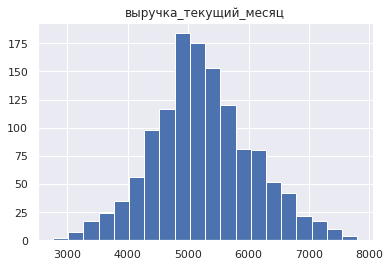

In [40]:
money_info['выручка_текущий_месяц'].hist(bins=20)
plt.title('выручка_текущий_месяц');

Далее представлна информации о проведенном на сайте времени.

In [41]:
time_info.describe()

id  минут_предыдущий_месяц  минут_текущий_месяц
count    1299.000000             1299.000000          1299.000000
mean   215997.975366               13.468822            13.204003
std       375.174972                3.933332             4.222157
min    215348.000000                5.000000             4.000000
25%    215673.500000               11.000000            10.000000
50%    215998.000000               13.000000            13.000000
75%    216322.500000               17.000000            16.000000
max    216647.000000               23.000000            23.000000

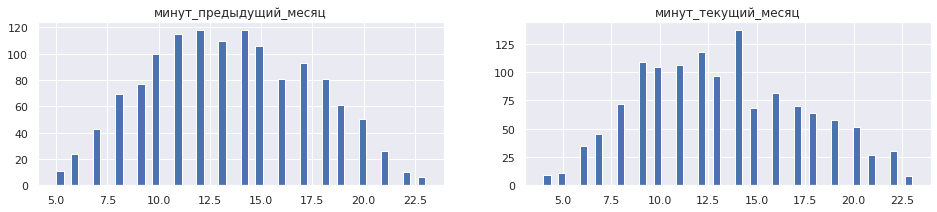

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,3))
i = 0
for col in time_info.columns[1:].tolist():
    ax[i].hist(x=time_info[col], bins=50)
    ax[i].set_title(col)
    i += 1

Медианное значение времени, проведённого на сайте, в минутах в предыдущем месяце составляет 13 при минимальном 5 и максимальном 23. Распределение нормальное.
Медианное значение времени, проведённого на сайте, в минутах в текущем месяце составляет 13 при минимальном 4 и максимальном 23. Распределение близкое к нормальному.

Далее представлена информация о прибыли.

In [43]:
profits_info.describe()

id      Прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

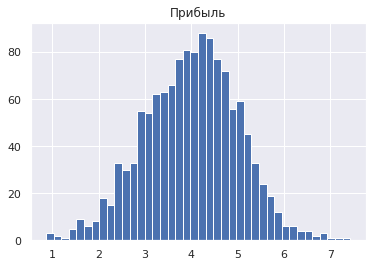

In [44]:
profits_info['Прибыль'].hist(bins=40)
plt.title('Прибыль');

Медианное значение выручки составляет 4.05 при минимальном 0.86 и максимальном 7.43. Распределение нормальное. Медианное значение времени, проведённого на сайте, в минутах в текущем месяце составляет 13 при минимальном 4 и максимальном 23. Распределение нормальное. 

**ВЫВОД**  

В данном разделе был проведен исследовательский анализ данных:

1. Медианное среднемесячное значение **маркетинговых коммуникаций** компании, которое приходилось на покупателя за последние 6 месяцев составляет 4.2 при минимальном 0.9 и максимальном 6.6. Для клиентов со сниженным уровнем активности значение признака ниже, а распределение близкое к нормальному. Распределение покупателей со с прежнем уровнем активности - бимодальное. Присутствуют выбросы, но в пределах реальных значений. Значение параметра выше для клиентов с прежним уровнем активности.


2. Медианное количество **маркетинговых коммуникаций** в текущем месяце составляет 4 при минимальном 3 и максимальном 5. На покупателей с прежнем уровнем активности реже приходилось 5 коммуникаций за текущий в месяц. Статистические выбросы в пределах реальных значений.

3. Медианное значение, которое показывает, сколько **дней** прошло с момента регистрации покупателя на сайте, составляет 606 при минимальном 110 и максимальном 1079. Распеределение близкое к нормальному. Параметр в пределах допустимых значений.

4. Медианная среднемесячная доля покупок **по акции** от общего числа покупок за последние 6 месяцев составляет 0.24 при минимальном 0 и максимальном 0.99. Параметр распределен по 2 категориям: кто часто покупает акционные товары и те,чья доля составляет менее 0.5. Бимодальное распределение для клиентов со сниженной активностью - они чаще покупают товары по акции. Выбросы для категории клиентов с прежним уровнем активности в пределах реальных значений.

5. Медианное число просмотренных **категорий за визит** в течение последнего месяца составляет 3 при минимальном 1 и максимальном 6. Распределение правостороннее для категории покупателей со сниженной активностью и мультимодальное - для клиентов с прежнем уровнем активности. Значение параметра выше для клиентов с прежней покупательской активностью.

6. Медианное общее число **неоплаченных товаров** в корзине за последние 3 месяца составляет 3 при минимальном 0 и максимальном 10. Распределение правостороннее. Значение параметра выше для категории покупателей со сниженной активностью. Есть несколько выбросов у обоих категорий клиентов, но в пределах реальных значений.

7. Медианное число **сбоев**, которые коснулись покупателя во время посещения сайта, составляет 4 при минимальном 0  и максимальном 9. Распределение нормальное для клиентов с прежней покупательской активностью и правостороннее - для клиентов со сниженной активностью. Параметр в пределах допустимых значений.

8. Медианное среднее количество **страниц**, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, составляет 8 при минимальном 1 и максимальном 20. Распределение правостороннее. Значение параметра выше для категории покупателей с прежней активностью. Есть несколько выбросов для клиентов со сниженной активностью, но в пределах реальных значений.

9. 61.7% пользователей имеют класс **покупательской активности** "Прежний уровень", у 38.3% активность снизилась.

10. 71.1% пользователей имею стандартный **тип сервиса**, и 28.9% - премиум.

11. 74% разрешили **присылать предложения**, 26% - отказались.

12. Товары для детей - самая **популярная категория** для 25.4%. Далее идут: домашний текстиль, косметика и аксессуары, техника для красоты и здоровья, мелкая бытовая техника и электроника, кухонная посуда.

13. Медианное значение **выручки** в препредыдущем месяце составляет 4809 при минимальном 0 и максимальном 5663. Распределение правостороннее близкое к нормальному.

14. Медианное значение **выручки** в предыдущем месяце составляет 5005 при минимальном 0 и максимальном 6869. Распределение левостороннее.

15. Медианное значение **выручки** в текущем месяце составляет 5179 при минимальном 2758.7 и максимальном 7799.4 после исключения выброса. Распределение нормальное.

16. Медианное значение **времени**, проведённого на сайте, в минутах в предыдущем месяце составляет 13 при минимальном 5 и максимальном 23. Распределение нормальное.

17. Медианное значение **времени**, проведённого на сайте, в минутах в текущем месяце составляет 13 при минимальном 4 и максимальном 23. Распределение близкое к нормальному.

18. Медианное значение **выручки с клиента** за 3 месяца составляет 4.05 при минимальном 0.86 и максимальном 7.43. Распределение нормальное. 

## Объединение таблиц

В данном разделе было проведено объединение таблиц. Новый датасет имеет 18 параметров, включая id, и 1299 строк без пропусков.

In [45]:
df_full = money_info.merge(customers_info, on = 'id', how='left').merge(time_info, on = 'id', how='left')

In [46]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   выручка_предыдущий_месяц             1296 non-null   float64
 2   выручка_препредыдущий_месяц          1296 non-null   float64
 3   выручка_текущий_месяц                1296 non-null   float64
 4   Покупательская_активность            1296 non-null   object 
 5   Тип_сервиса                          1296 non-null   object 
 6   Разрешить_сообщать                   1296 non-null   object 
 7   Маркет_актив_6_мес                   1296 non-null   float64
 8   Маркет_актив_тек_мес                 1296 non-null   int64  
 9   Длительность                         1296 non-null   int64  
 10  Акционные_покупки                    1296 non-null   float64
 11  Популярная_категория          

## Корреляционный анализ

В данном разделе был проведен корреляционный анализ признаков в количественной шкале и и проведена проверка на мультиколлинеарность.

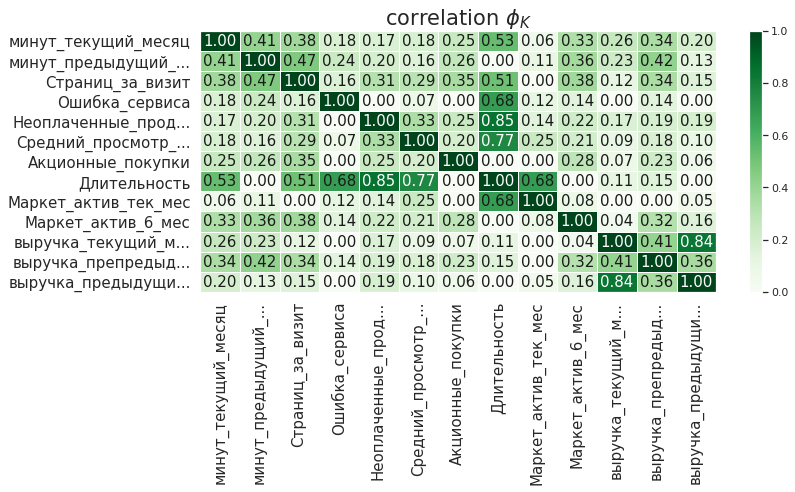

In [47]:

# создаём список с наименованиями непрерывных признаков
interval_cols = ['минут_текущий_месяц', 
                 'минут_предыдущий_месяц', 
                 'выручка_препредыдущий_месяц', 
                 'выручка_предыдущий_месяц', 
                 'выручка_текущий_месяц', 
                 'Маркет_актив_6_мес', 
                 'Акционные_покупки']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df_full.drop('id', axis=1).select_dtypes('number'), interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(12, 7)
) 

При пороге корреляции 0.9, мультиколлинеарность не была обнаружена.

low activity


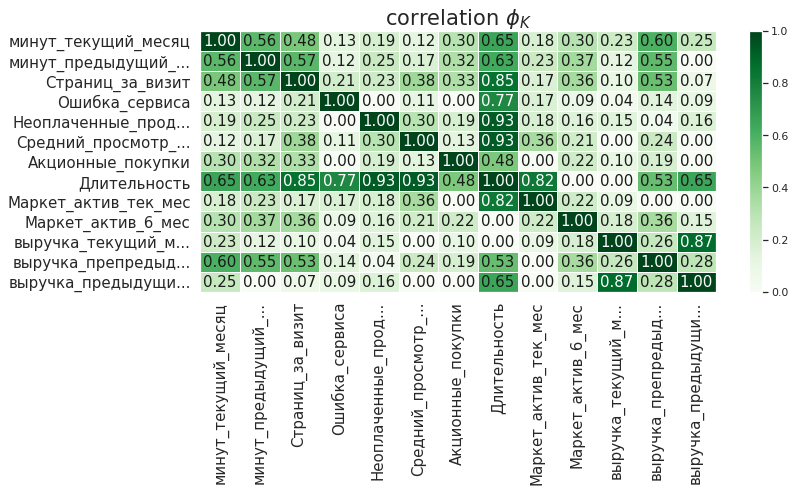

In [48]:
phik_overview = phik_matrix(df_full.drop('id', axis=1)[df_full['Покупательская_активность'] == 'Снизилась'].select_dtypes('number'), interval_cols=interval_cols) 
print('low activity')
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(12, 7)
) 

high activity


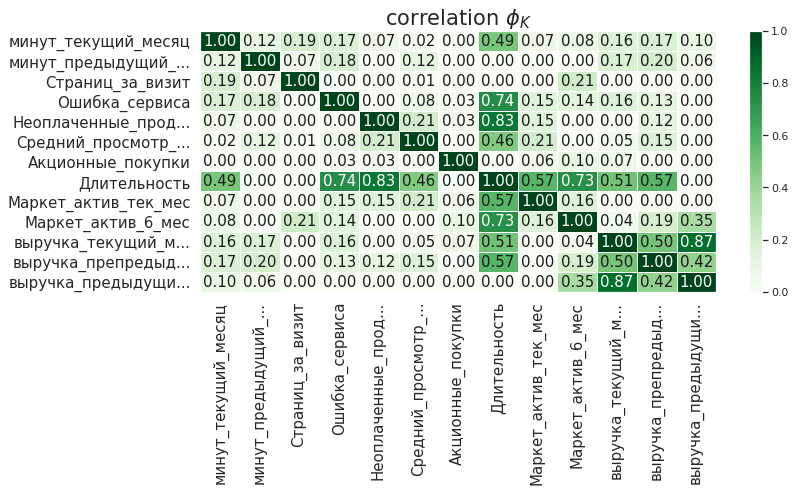

In [49]:
phik_overview = phik_matrix(df_full.drop('id', axis=1)[df_full['Покупательская_активность'] == 'Прежний уровень'].select_dtypes('number'), interval_cols=interval_cols) 
print('high activity')
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(12, 7)
) 

Из сравнения матриц корреляции, можно заметить, что признаки клиентов со сниженной покупательской активностью имеют больше зависимости между друг другом.

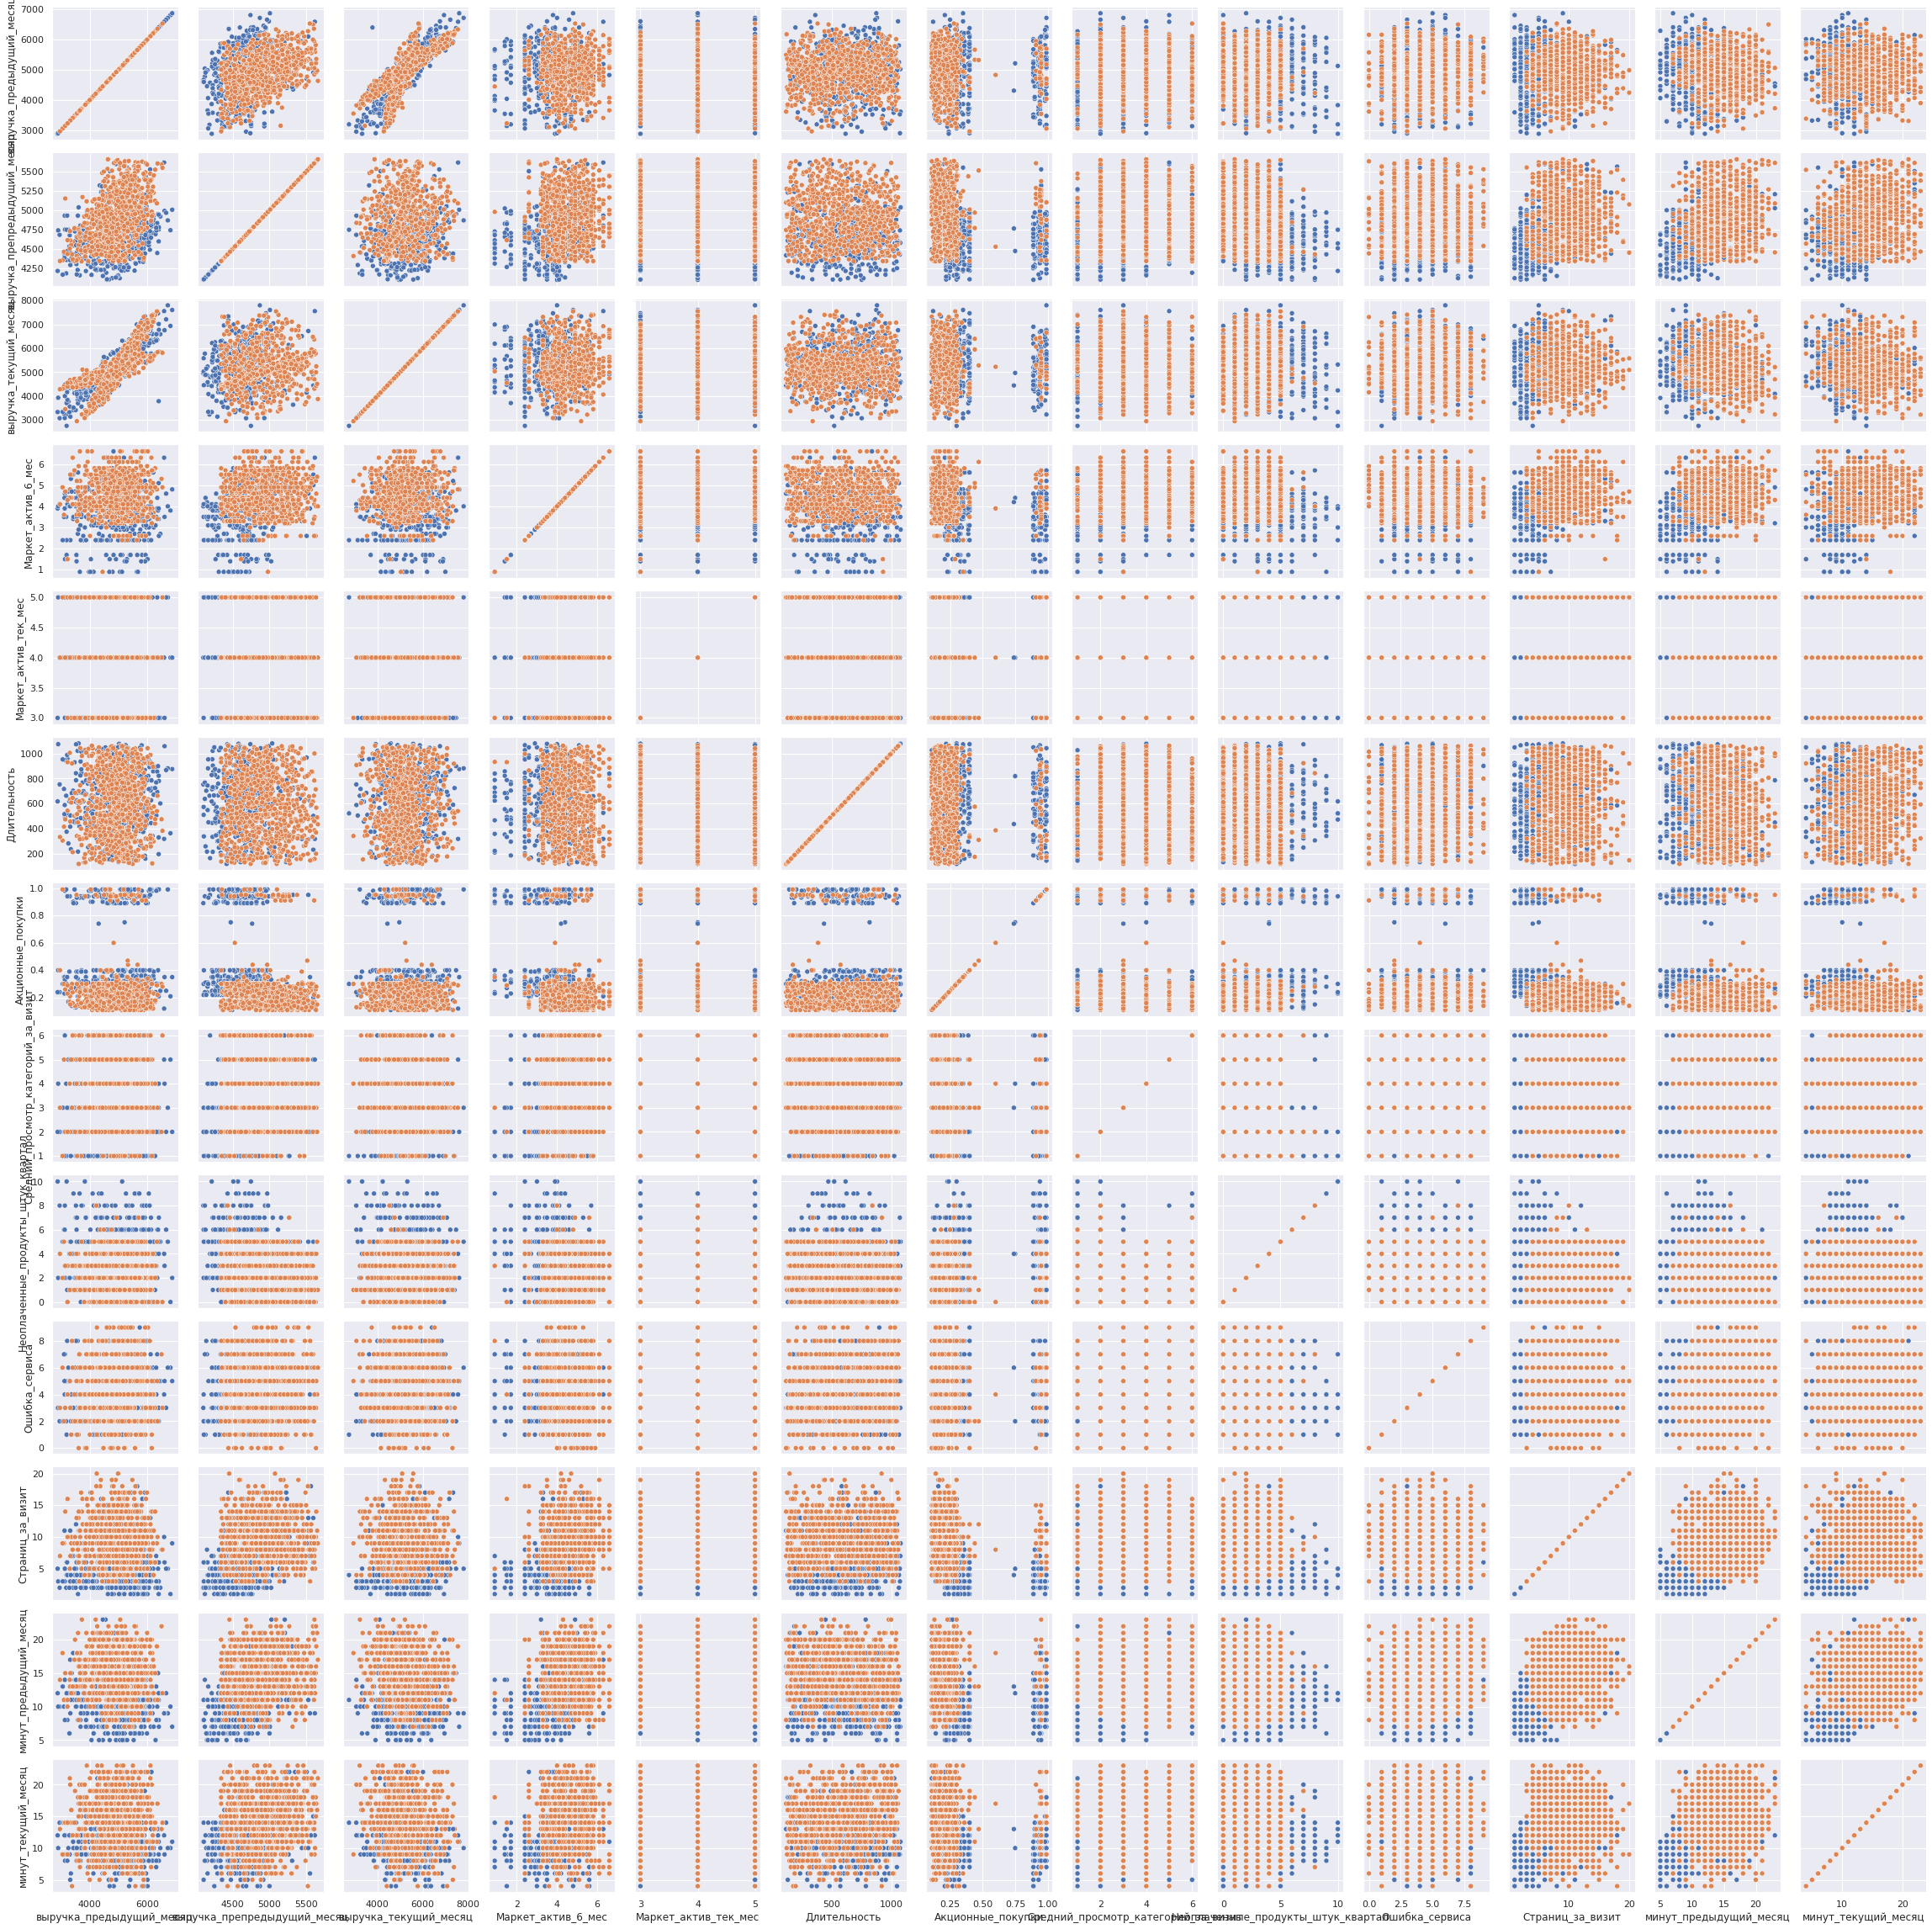

In [50]:
g = sns.PairGrid(df_full.drop('id', axis=1).drop(columns=['Тип_сервиса', 'Разрешить_сообщать', 'Популярная_категория']), hue='Покупательская_активность');
g.map(sns.scatterplot);

При обзоре матрицы рассеивания была определена сильная линейная зависимость между выручкой предыдущего и текущего месяца. Ниже представлена диагрмма рассеивания данных параметров.

In [51]:
sns.scatterplot(data=df_full, x=df_full['выручка_предыдущий_месяц'], y=df_full['выручка_текущий_месяц'], hue='Покупательская_активность');

Для дальнейшего анализа были созданы параметры: изменение выручки в предыдущем месяца, сумма выручек предыдущего и препредыдущего месяцев.

In [52]:
df_full['разница_препред_и_пред'] = df_full['выручка_предыдущий_месяц'] - df_full['выручка_препредыдущий_месяц']
df_full['сумма_препред_и_пред'] = df_full['выручка_препредыдущий_месяц'] + df_full['выручка_предыдущий_месяц']

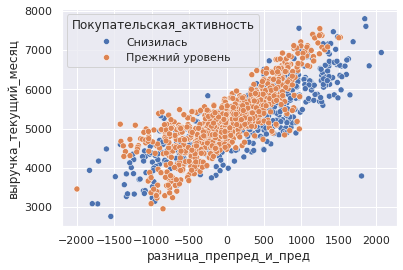

In [53]:
sns.scatterplot(data=df_full, x=df_full['разница_препред_и_пред'], y=df_full['выручка_текущий_месяц'], hue='Покупательская_активность');

Чем больше возрасла выручка за предыдущий период по сравнению с препредыдущий, тем больше выручка в текущем.

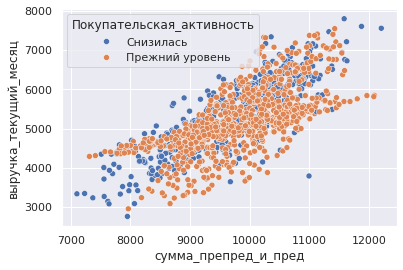

In [54]:
sns.scatterplot(data=df_full, x=df_full['сумма_препред_и_пред'], y=df_full['выручка_текущий_месяц'], hue='Покупательская_активность');

Чем больше сумма выручек за предыдущий и препредыдущий периоды, тем больше выручка в текущем.

In [55]:
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(df_full.drop('id', axis=1).select_dtypes('number'), interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(12, 7)
) 

The number of unique values of variable сумма_препред_и_пред is large: 1148. Are you sure this is not an interval variable? Analysis for pairs of variables including сумма_препред_и_пред can be slow.


Новая матрица отображает сильную корреляцию между созданными параметрами и старыми признаками. Кроме того, такая высокая корреляция позволит спрогнозировать расходы клиента за текущий месяц по данным прошедших периодов.

In [56]:
df_full = df_full.iloc[:, :18]

**ВЫВОД**  

В данном разделе были при пороге корреляции 0.9 мультиколлинеарность не была обнаружена. Была обнаружена сильная линейная зависимость между текущей выручкой и показателями выручки предыдущих периодов. Таким образом, это может позволить спрогнозировать расходы клиента за текущий месяц по данным прошедших периодов.

## Использование пайплайнов

В данном разделе будет осуществлен подбор модели для прогнозирования покупательской активности и наилучших параметров для нее.

Датасет разделен на тренировочный и тестовый наборы данных. Тренировочный содержит 974 записи, тестовый - 325.  
Также для дальнейшей работы создан тестовый набор x_Test, который будет использован при сегментировании.

In [57]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_full.drop(['Покупательская_активность'], axis=1),
    df_full['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_full['Покупательская_активность'])
x_Test = X_test.copy()
X_train.drop('id', axis=1, inplace=True)
X_test.drop('id', axis=1, inplace=True)
X_train.shape, X_test.shape

((972, 16), (324, 16))

Произведено кодирование целевого признака. Новые значения представлены ниже.

In [58]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

print(pd.DataFrame(index=y_train, data=label_encoder.transform(y_train), columns=['LabelEncoder']).drop_duplicates())

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test) 

                           LabelEncoder
Покупательская_активность              
Прежний уровень                       0
Снизилась                             1


Далее были созданы шаги по подготовке данных.

In [59]:
df_full.columns

Index(['id', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц',
       'выручка_текущий_месяц', 'Покупательская_активность', 'Тип_сервиса',
       'Разрешить_сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
       'Длительность', 'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц'],
      dtype='object')

In [60]:
ohe_columns = ['Тип_сервиса', 
               'Разрешить_сообщать', 
               'Популярная_категория']

num_columns = ['Маркет_актив_6_мес', 
               'Маркет_актив_тек_мес', 
               'Средний_просмотр_категорий_за_визит', 
               'Неоплаченные_продукты_штук_квартал', 
               'Ошибка_сервиса', 'Страниц_за_визит', 
               'минут_предыдущий_месяц', 
               'минут_текущий_месяц', 
               'выручка_предыдущий_месяц', 
               'выручка_препредыдущий_месяц', 
               'выручка_текущий_месяц',
               'Акционные_покупки',
               'Длительность']

In [61]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
)

In [62]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [63]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

Далее были сформированы словари для моделей DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression с параметрами для перебора.

In [64]:
param_grid = [
    # DecisionTreeClassifier
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # KNeighborsClassifier
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # LogisticRegression
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

Для поиска опатимального решения был выбран способ RandomizedSearchCV. Для оценки качества работы модели была выбрана метрика ROC-AUC, так как работает вне зависимости от выбранного порога вероятности и иетрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.  

Наилучшей моделью была выбрана LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear') при масштабировании с применением RobustScaler.

In [65]:
%%time
grid = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Тип_сервиса',
                                                   'Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                                   'Средний_просмотр_категорий_за_визит',
                       

In [66]:
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.896324356587993


In [67]:
# применяем обученную модель на тестовой выборке
preds = grid.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, preds[:,1])}') 

Метрика ROC-AUC на тестовой выборке: 0.9171621566961938


**ВЫВОД**  

В данном разделе был осуществлен подбор модели для прогнозирования покупательской активности и наилучших параметров для нее. Наилучшей моделью была выбрана LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear') при масштабировании с применением RobustScaler. Метрика ROC-AUC лучшей модели на тренировочной выборке: 0.8997. Метрика ROC-AUC на тестовой выборке: 0.862.

## Анализ важности признаков

В данном разделе была проведена оценка важности признаков для лучшей модели.

Была проведена подготовка данных для метода SHAP.

In [68]:
X_train_p = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_p = pipe_final.named_steps['preprocessor'].transform(X_test)

X_train_p = pd.DataFrame(X_train_p, columns = data_preprocessor.get_feature_names_out())
X_test_p = pd.DataFrame(X_test_p, columns = data_preprocessor.get_feature_names_out())

explainer = shap.LinearExplainer(grid.best_estimator_.named_steps['models'], X_train_p)

In [69]:
%%time
shap_values = explainer(X_test_p)

CPU times: user 13.2 ms, sys: 3.91 ms, total: 17.2 ms
Wall time: 13.5 ms


Самым большим весом обладают параметры: Количество страниц за визит, среднее число просматриваемых категорий за визит, проведенное время на сайте, а также количество неоплаченных товаров.

In [70]:
shap.plots.bar(shap_values, max_display=10) 

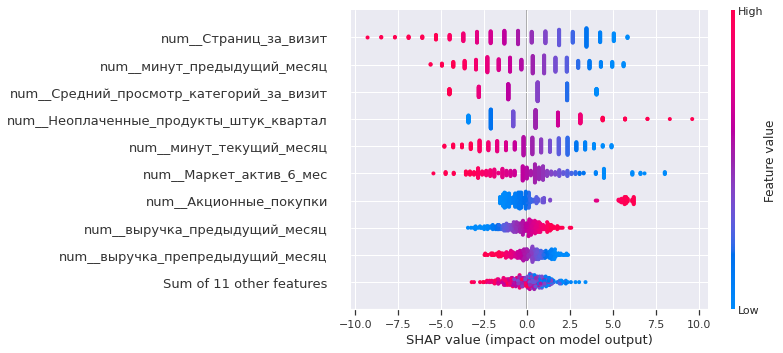

In [71]:
shap.plots.beeswarm(shap_values, max_display=10) 

При этом чем меньше количество страниц за визит, среднее число просматриваемых категорий за визит, а также проведенное время на сайте, тем с большей вероятность можно прогнозировать снижение покупательской активности. Также большое количество неоплаченных товаров также повышает вероятность прогнозировать снижение активности. Помимо этого, высокая доля акционных товаров негативно влияет на прогнозируемую покупательскую активность.

**ВЫВОД**  

В данном разделе была проведена оценка важности признаков для лучшей модели. Самым большим весом обладают параметры: Количество страниц за визит, среднее число просматриваемых категорий за визит, проведенное время на сайте, а также количество неоплаченных товаров. При этом чем меньше количество страниц за визит, среднее число просматриваемых категорий за визит, а также проведенное время на сайте, тем с большей вероятность можно прогнозировать снижение покупательской активности. Также большое количество неоплаченных товаров также повышает вероятность прогнозировать снижение активности.

## Сегментация покупателей

В данном разделе была проведена сегментация покупателей с учетом результатов моделирования и данных о прибыльности покупателей.

Ниже представлена диаграмма рассеивания для тестовой выборки по прибыльности покупателей и вероятности снижения покупательской активности.

In [72]:
df_activity_proba = x_Test.copy()
x_Test.drop('id', axis = 1, inplace=True)

In [73]:
x_Test = pipe_final.named_steps['preprocessor'].fit_transform(x_Test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
df_activity_proba['proba'] = grid.best_estimator_['models'].predict_proba(x_Test)[:,1].round(2)

In [74]:
df_activity_proba = profits_info.merge(df_activity_proba, on = 'id', how='right')

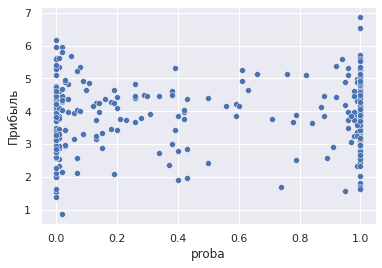

In [75]:
sns.scatterplot(data=df_activity_proba, x='proba', y='Прибыль');

Для построения графиков были подготовлены данные с информацией о покупателях и вероятностью снижения их покупательской активности. В исследуемые данные вошли 20% наиболее прибыльных клиентов, а также клиенты с шансом снижения покупательской активности ниже 20% и больше 80%. Клиенты с высоким шансом снижения покупательской активности отнесены к группе риска и будут сравнены с эталоном в виде клиентов с низким шансом снижения.

In [76]:
df_activity_proba['Шанс_снижения'] = \
    pd.cut(
        df_activity_proba['proba'], 
        [0.00, 0.2, 0.8, np.inf], 
        labels=['Низкий', 'Средний', 'Высокий'], 
        include_lowest=True
    )

df_activity_proba = \
    df_activity_proba[ \
        (df_activity_proba['Шанс_снижения']=='Низкий') | \
        (df_activity_proba['Шанс_снижения']=='Высокий') & \
        (df_activity_proba['Прибыль']>df_activity_proba['Прибыль'].quantile(.8))
    ]

df_activity_proba['Шанс_снижения'] = df_activity_proba['Шанс_снижения'].cat.remove_unused_categories()

Итоговая таблица представлена ниже.

In [77]:
df_activity_proba.head()

id  Прибыль  выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
0  216161     4.69                    3973.0                       4912.0   
2  216307     3.16                    5444.0                       4565.0   
5  216576     3.20                    4334.0                       5150.0   
6  216465     2.03                    5505.5                       5180.0   
7  216527     3.26                    4668.0                       5023.0   

   выручка_текущий_месяц Тип_сервиса Разрешить_сообщать  Маркет_актив_6_мес  \
0                 3289.2    стандарт                 да                 4.1   
2                 6335.8     премиум                 да                 3.3   
5                 3756.8    стандарт                 да                 5.8   
6                 5917.6    стандарт                 да                 4.9   
7                 5106.1    стандарт                нет                 4.9   

   Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                     4           606               0.15   
2                     4           488               0.13   
5                     4           176               0.28   
6                     4           739               0.17   
7                     3           679               0.15   

                   Популярная_категория  Средний_просмотр_категорий_за_визит  \
0        Техника для красоты и здоровья                                    6   
2                     Домашний текстиль                                    4   
5                     Домашний текстиль                                    6   
6  Мелкая бытовая техника и электроника                                    5   
7        Техника для красоты и здоровья                                    4   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  \
0                                   1               4                12   
2                                   2               8                10   
5                                   2               4                 6   
6                                   1               4                 4   
7                                   1               1                14   

   минут_предыдущий_месяц  минут_текущий_месяц  proba Шанс_снижения  
0                      16                   17   0.00        Низкий  
2                      20                   11   0.06        Низкий  
5                      18                   15   0.00        Низкий  
6                      18                   15   0.00        Низкий  
7                      12                   19   0.00        Низкий

In [78]:
def show_segments_num(df, column):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,6))
    fig.suptitle(f'Параметр: {column}', fontsize=15)


    sns.histplot(df, x=column, hue="Шанс_снижения", shrink=1, alpha=.5, legend=True, ax=axes[0])
    axes[0].set_title('Гистограмма распределения')

    sns.boxplot(y=df[column], hue = df['Шанс_снижения'], ax=axes[1], fill=False, gap=.1)
    axes[1].set_title('Разброс значений признаков')
    axes[1].legend(loc=1)

    plt.show()

def show_segments_cat(df, column):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    fig.suptitle(f'Параметр: {column}', fontsize=15)
    ax[0].pie(x=df[df['Шанс_снижения']=='Низкий'][column].value_counts().sort_values(), 
                  autopct='%1.1f%%') 
    ax[0].set_title('Низкий шанс снижения')
    ax[0].legend(labels = df[column].value_counts().sort_values().index, loc="upper center", bbox_to_anchor=(0.5, 0))

    ax[1].pie(x=df[df['Шанс_снижения']=='Высокий'][column].value_counts().sort_values(), 
                  autopct='%1.1f%%') 
    ax[1].set_title('Высокий шанс снижения')
    ax[1].legend(labels = df[column].value_counts().sort_values().index, loc="upper center", bbox_to_anchor=(0.5, 0))
    plt.show()

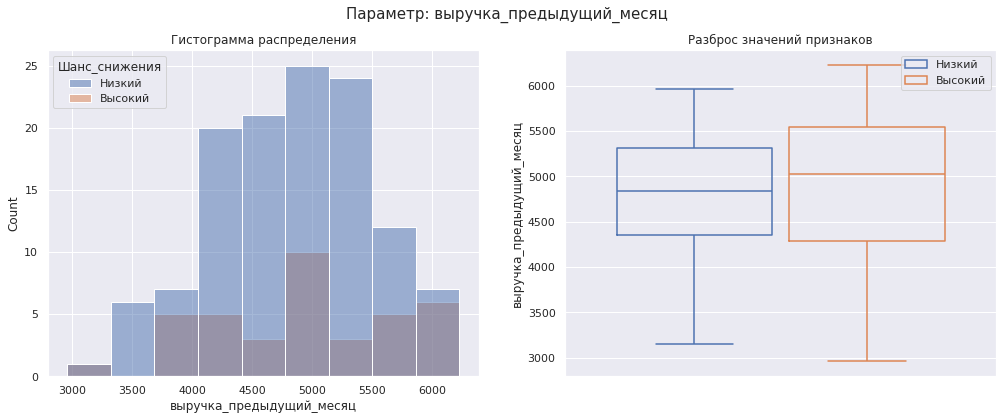

In [79]:
show_segments_num(df_activity_proba, 'выручка_предыдущий_месяц')

Медианная выручка предыдущего месяца слегка выше у группы риска.

In [80]:
show_segments_num(df_activity_proba, 'выручка_препредыдущий_месяц')

Медианная выручка препредыдущего месяца значительно больше у эталонной группы.

In [81]:
show_segments_num(df_activity_proba, 'выручка_текущий_месяц')

Выручка в текущем месяце похожа у обеих групп.

In [82]:
show_segments_num(df_activity_proba, 'Маркет_актив_6_мес')

Среднемесячное число маркетинговых взаимодействий с группой риска значительно меньше. Необходимо увеличивать количество взаимодействий и вводить систематичный подход.

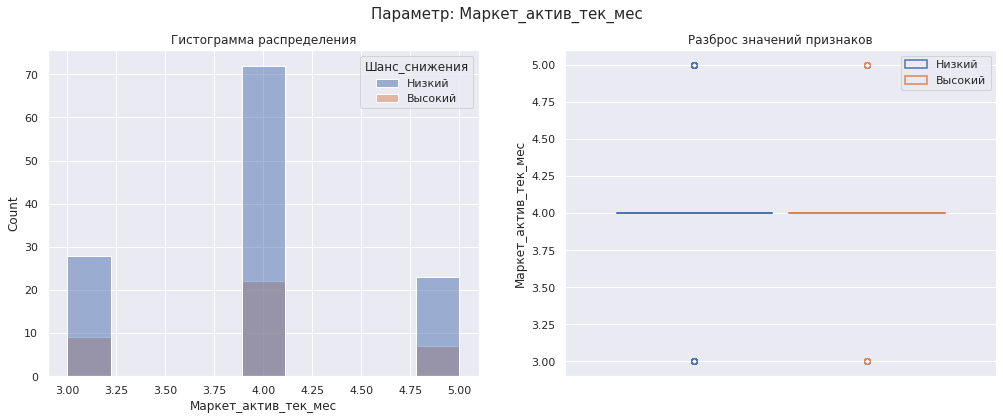

In [83]:
show_segments_num(df_activity_proba, 'Маркет_актив_тек_мес')

Количество маркетинговых взаимодействий в текущем месяце распределено приблизительно одинаково для обеих групп.

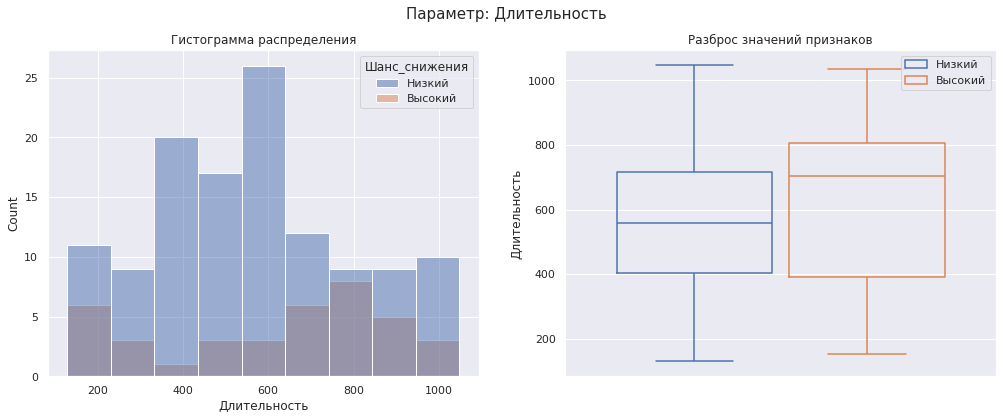

In [84]:
show_segments_num(df_activity_proba, 'Длительность')

Медианная длительность с момента регистрации для группы риска больше. 

In [85]:
show_segments_num(df_activity_proba, 'Акционные_покупки')

Группа риска обладает более высоким показателем доли акционных товаров.

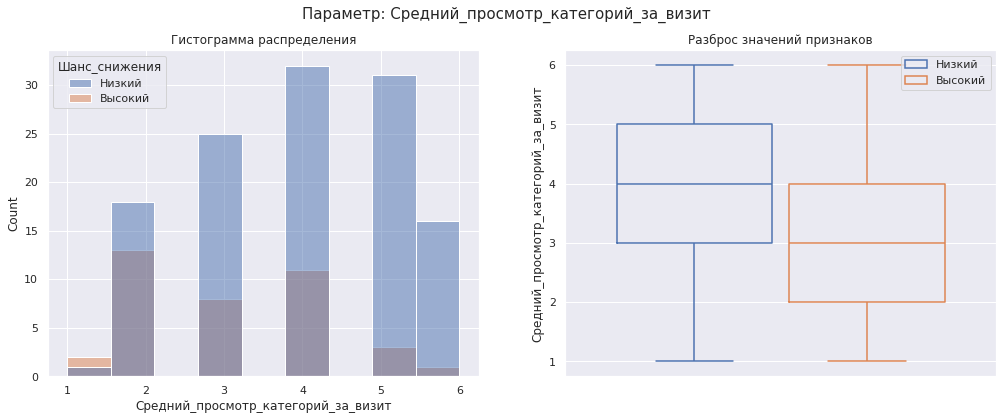

In [86]:
show_segments_num(df_activity_proba, 'Средний_просмотр_категорий_за_визит')

Группа риска просматривает меньше категорий за визит. Для увеличения числа просматриваемых категорий можно сделать подборки рекоммендаций и тематические подборки, чтобы дать пользователю возможность изучить различные нетипичные категории через новинки, рекоммендации экспертов, обзоры, рекоммендации по выбору.

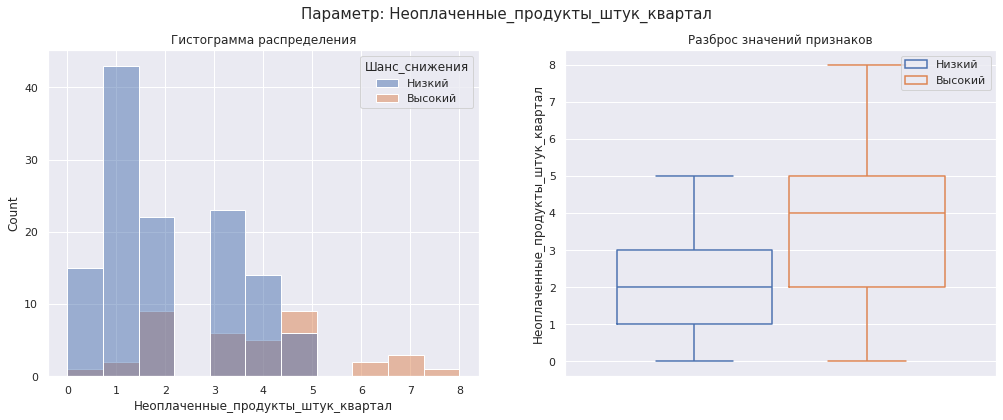

In [87]:
show_segments_num(df_activity_proba, 'Неоплаченные_продукты_штук_квартал')

Клиенты из группы риска имеют большее количество неоплаченных продуктов. Для сокращения числа неоплаченных товаров в корзине, предлагается напоминать о товарах на почту или через оповещения приложения, оповещать, если товар скоро закончится, а также предлагать рассмотреть другие похожие товары.

In [88]:
show_segments_num(df_activity_proba, 'Ошибка_сервиса')

В среднем эталонная группа чаще сталкивается со сбоями сервиса. Количество ошибок сайта не повлияло на снижение покупательской способности, судя по сравнению.

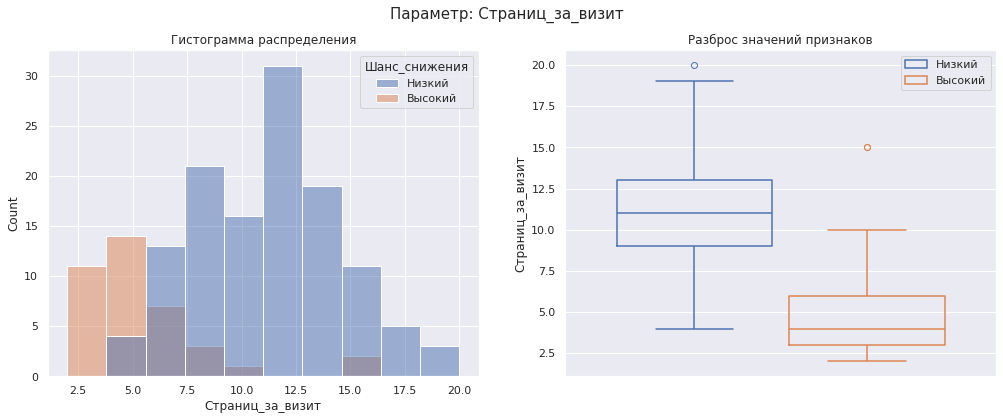

In [89]:
show_segments_num(df_activity_proba, 'Страниц_за_визит')

Группа риска просматривает меньше страниц за визит. Для увеличения числа просматриваемых страниц можно сделать подборки рекоммендаций и тематические подборки, новинки, рекоммендации экспертов, обзоры, рекоммендации по выбору.

In [90]:
show_segments_num(df_activity_proba, 'минут_предыдущий_месяц')

Эталонная группа провела больше времени на сайте в предыдущем месяце. Для увеличения проводимого на сайте времени, можно сделать подборки рекоммендаций и тематические подборки, рекоммендации экспертов, обзоры, рекоммендации по выбору, рецепты.

In [91]:
show_segments_num(df_activity_proba, 'минут_текущий_месяц')

Эталонная группа провела больше времени на сайте в текущем месяце. Для увеличения проводимого на сайте времени, можно сделать подборки рекоммендаций и тематические подборки, рекоммендации экспертов, обзоры, рекоммендации по выбору, рецепты.

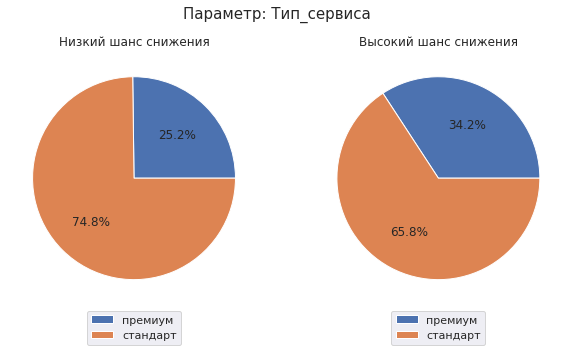

In [92]:
show_segments_cat(df_activity_proba, 'Тип_сервиса')

Группа с высоким риском снижения покупательской активности обладает большей долей премиального типа сервиса. 

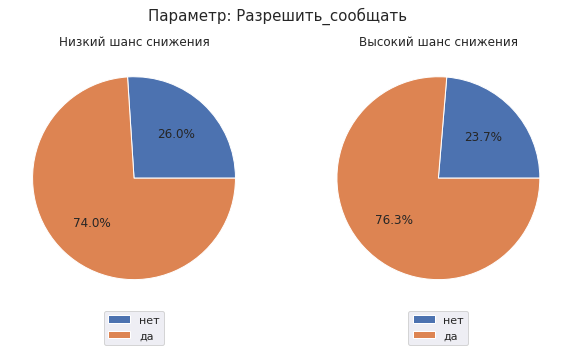

In [93]:
show_segments_cat(df_activity_proba, 'Разрешить_сообщать')

Группа с высоким риском снижения покупательской активности обладает слегка большей долей тех, кто согласился на информирование.

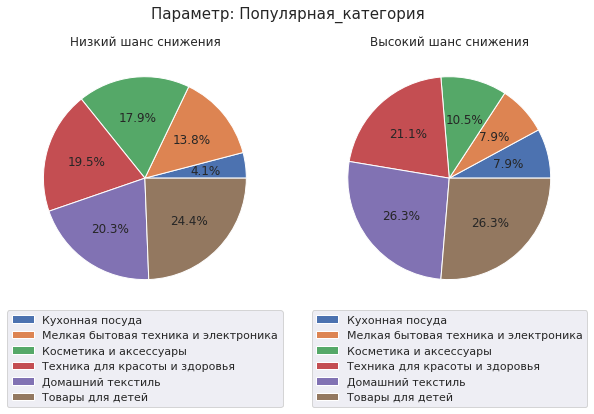

In [94]:
show_segments_cat(df_activity_proba, 'Популярная_категория')

Клиенты группы риска чаще покупают товары для детей, домашний текстиль  и технику для красоты и здоровья. ТОП-3 категории для эталонной группы такие же, но обладают меньшей долей в распределении. Косметика и аксессуры, мелкая техника и электроника для эталонной группы популярнее, чем для группы риска. Это может быть обусловлено малой осведомленностью о таких категориях или сомнениями о качестве/оригинальности данных товаров. Можно сделать оповещение или публикацию о возможности купить такие товары на маркетплейсе, а также о гарантиях.

**ВЫВОД**

В данном разделе была проведена сегментация покупателей с учетом результатов моделирования и данных о прибыльности покупателей. Было выделено 2 категории клиентов: группа риска - с высокой прибольностью, но высоким шансом снижения покупательской способности, и эталонная группа - с высокой прибольностью с низким шансом снижения покупательской способности.

- Медианная выручка предыдущего месяца слегка выше у группы риска. Медианная выручка препредыдущего месяца значительно больше у эталонной группы. Выручка в текущем месяце похожа у обеих групп.

- Среднемесячное число маркетинговых взаимодействий с группой риска значительно меньше. Необходимо увеличивать количество взаимодействий и вводить систематичный подход.

- Количество маркетинговых взаимодействий в текущем месяце распределено приблизительно одинаково для обеих групп.

- Медианная длительность с момента регистрации для группы риска больше. Кроме того, группа с высоким риском снижения покупательской активности обладает большей долей премиального типа сервиса. Группа с высоким риском снижения покупательской активности обладает слегка большей долей тех, кто согласился на информирование. Не смотря на это, с этой группой осуществляется в среднем меньше маркетинговых коммуникаций.

- Группа риска обладает более высоким показателем доли акционных товаров. Для сокращения доли акционных товаров необходимо развивать лояльность к маркетплейсу и формировать индивидуальные предложения для все большей вовлеченности клиента и развития постоянного взаимодействия. Интеграция сервиса в повседневную жизнь снизит долю акционных товаров.

- Группа риска просматривает меньше страниц и категорий за визит, а также проводит меньше времени на сайте. Для увеличения числа просматриваемых категорий можно сделать подборки рекоммендаций и тематические подборки, чтобы дать пользователю возможность изучить различные нетипичные категории через новинки, рекоммендации экспертов, обзоры, рекоммендации по выбору, рецепты. Также на указанные характеристики может повлиять отправка различных сезонных и тематических предложений, например "8 марта совсем скоро! Заходите в приложение и выбирайте подарки!" или "Как насчет уютного вечера и яблочного пирога? Поделимся рецептом и привезем продукты!" , и бонусы на покупки свыше определенной суммы.

- Клиенты из группы риска имеют большее количество неоплаченных продуктов. Для сокращения числа неоплаченных товаров в корзине, предлагается напоминать о товарах на почту или через оповещения приложения, оповещать, если товар скоро закончится, а также предлагать рассмотреть другие похожие товары.

- В среднем эталонная группа чаще сталкивается со сбоями сервиса. Количество ошибок сайта не повлияло на снижение покупательской способности, судя по сравнению.

- Клиенты группы риска чаще покупают товары для детей, домашний текстиль и технику для красоты и здоровья. ТОП-3 категории для эталонной группы такие же, но обладают меньшей долей в распределении. Косметика и аксессуры, мелкая техника и электроника для эталонной группы популярнее, чем для группы риска. Это может быть обусловлено малой осведомленностью о таких категориях или сомнениями о качестве/оригинальности данных товаров. Можно сделать оповещение или публикацию о возможности купить такие товары на маркетплейсе, а также о гарантиях.

## Общий вывод

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

В рамках проекта необходимо разработать модель прогнозирования снижения покупательской активности,а также используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

**Исследование включало в себя 9 разделов:**
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение таблиц
5. Корреляционный анализ
6. Использование пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод


**1. ЗАГРУЗКА ДАННЫХ**  
В данном разделе были загружены и описаны 4 датасета для дальнейшей работы.

**2. ПРЕДОБРАБОТКА ДАННЫХ**  
В данном разделе была проведена предобработка данных: исправлены некорректные наименования, трансформированы таблицы к единому формату, проведена проверка на дубликаты, пропуски и корректность формата данных.

**3. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ**  
В данном разделе был проведен исследовательский анализ данных:

1. Медианное среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев составляет 4.2 при минимальном 0.9 и максимальном 6.6. Для клиентов со сниженным уровнем активности значение признака ниже, а распределение близкое к нормальному. Распределение покупателей со с прежнем уровнем активности - бимодальное. Присутствуют выбросы, но в пределах реальных значений. Значение параметра выше для клиентов с прежним уровнем активности.


2. Медианное количество маркетинговых коммуникаций в текущем месяце составляет 4 при минимальном 3 и максимальном 5. На покупателей с прежнем уровнем активности реже приходилось 5 коммуникаций за текущий в месяц. Статистические выбросы в пределах реальных значений.

3. Медианное значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте, составляет 606 при минимальном 110 и максимальном 1079. Распеределение близкое к нормальному. Параметр в пределах допустимых значений.

4. Медианная среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев составляет 0.24 при минимальном 0 и максимальном 0.99. Параметр распределен по 2 категориям: кто часто покупает акционные товары и те,чья доля составляет менее 0.5. Бимодальное распределение для клиентов со сниженной активностью - они чаще покупают товары по акции. Выбросы для категории клиентов с прежним уровнем активности в пределах реальных значений.

5. Медианное число просмотренных категорий за визит в течение последнего месяца составляет 3 при минимальном 1 и максимальном 6. Распределение правостороннее для категории покупателей со сниженной активностью и мультимодальное - для клиентов с прежнем уровнем активности. Значение параметра выше для клиентов с прежней покупательской активностью.

6. Медианное общее число неоплаченных товаров в корзине за последние 3 месяца составляет 3 при минимальном 0 и максимальном 10. Распределение правостороннее. Значение параметра выше для категории покупателей со сниженной активностью. Есть несколько выбросов у обоих категорий клиентов, но в пределах реальных значений.

7. Медианное число сбоев, которые коснулись покупателя во время посещения сайта, составляет 4 при минимальном 0  и максимальном 9. Распределение нормальное для клиентов с прежней покупательской активностью и правостороннее - для клиентов со сниженной активностью. Параметр в пределах допустимых значений.

8. Медианное среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, составляет 8 при минимальном 1 и максимальном 20. Распределение правостороннее. Значение параметра выше для категории покупателей с прежней активностью. Есть несколько выбросов для клиентов со сниженной активностью, но в пределах реальных значений.

9. 61.7% пользователей имеют класс покупательской активности "Прежний уровень", у 38.3% активность снизилась.

10. 71.1% пользователей имею стандартный тип сервиса, и 28.9% - премиум.

11. 74% разрешили присылать предложения, 26% - отказались.

12. Товары для детей - самая популярная категория для 25.4%. Далее идут: домашний текстиль, косметика и аксессуары, техника для красоты и здоровья, мелкая бытовая техника и электроника, кухонная посуда.

13. Медианное значение выручки в препредыдущем месяце составляет 4809 при минимальном 0 и максимальном 5663. Распределение правостороннее близкое к нормальному.

14. Медианное значение выручки в предыдущем месяце составляет 5005 при минимальном 0 и максимальном 6869. Распределение левостороннее.

15. Медианное значение выручки в текущем месяце составляет 5179 при минимальном 2758.7 и максимальном 7799.4 после исключения выброса. Распределение нормальное.

16. Медианное значение времени, проведённого на сайте, в минутах в предыдущем месяце составляет 13 при минимальном 5 и максимальном 23. Распределение нормальное.

17. Медианное значение времени, проведённого на сайте, в минутах в текущем месяце составляет 13 при минимальном 4 и максимальном 23. Распределение близкое к нормальному.

18. Медианное значение выручки с клиента за 3 месяца составляет 4.05 при минимальном 0.86 и максимальном 7.43. Распределение нормальное. 

**4. ОБЪЕДИНЕНИЕ ТАБЛИЦ**  
В данном разделе было проведено объединение таблиц. Новый датасет имеет 18 параметров, включая id, и 1299 строк без пропусков.

**5. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ**  
В данном разделе были видоизменены параметры, отражающие траты покупателей, а также исключен параметр Длительность из-за сильной корреляции с многими другими признаками.

**6. ИСПОЛЬЗОВАНИЕ ПАЙПЛАЙНОВ**  
В данном разделе был осуществлен подбор модели для прогнозирования покупательской активности и наилучших параметров для нее. Наилучшей моделью была выбрана LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear') при масштабировании с применением MinMaxScaler. Метрика ROC-AUC лучшей модели на тренировочной выборке: 0.917. Метрика ROC-AUC на тестовой выборке: 0.862.

**7. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ**  
В данном разделе была проведена оценка важности признаков для лучшей модели. Самым большим весом обладают параметры: Количество страниц за визит, среднее число просматриваемых категорий за визит, проведенное время на сайте, а также количество неоплаченных товаров. При этом чем меньше количество страниц за визит, среднее число просматриваемых категорий за визит, а также проведенное время на сайте, тем с большей вероятность можно прогнозировать снижение покупательской активности. Также большое количество неоплаченных товаров также повышает вероятность прогнозировать снижение активности.

**8. СЕГМЕНТАЦИЯ ПОКУПАТЕЛЕЙ**  
В данном разделе была проведена сегментация покупателей с учетом результатов моделирования и данных о прибыльности покупателей. Было выделено 2 категории клиентов: группа риска - с высокой прибольностью, но высоким шансом снижения покупательской способности, и эталонная группа - с высокой прибольностью с низким шансом снижения покупательской способности.

- Медианная выручка предыдущего месяца слегка выше у группы риска. Медианная выручка препредыдущего месяца значительно больше у эталонной группы. Выручка в текущем месяце похожа у обеих групп.

- Среднемесячное число маркетинговых взаимодействий с группой риска значительно меньше. Необходимо увеличивать количество взаимодействий и вводить систематичный подход.

- Количество маркетинговых взаимодействий в текущем месяце распределено приблизительно одинаково для обеих групп.

- Медианная длительность с момента регистрации для группы риска больше. Кроме того, группа с высоким риском снижения покупательской активности обладает большей долей премиального типа сервиса. Группа с высоким риском снижения покупательской активности обладает слегка большей долей тех, кто согласился на информирование. Не смотря на это, с этой группой осуществляется в среднем меньше маркетинговых коммуникаций.

- Группа риска обладает более высоким показателем доли акционных товаров. Для сокращения доли акционных товаров необходимо развивать лояльность к маркетплейсу и формировать индивидуальные предложения для все большей вовлеченности клиента и развития постоянного взаимодействия. Интеграция сервиса в повседневную жизнь снизит долю акционных товаров.

- Группа риска просматривает меньше страниц и категорий за визит, а также проводит меньше времени на сайте. Для увеличения числа просматриваемых категорий можно сделать подборки рекоммендаций и тематические подборки, чтобы дать пользователю возможность изучить различные нетипичные категории через новинки, рекоммендации экспертов, обзоры, рекоммендации по выбору, рецепты. Также на указанные характеристики может повлиять отправка различных сезонных и тематических предложений, например "8 марта совсем скоро! Заходите в приложение и выбирайте подарки!" или "Как насчет уютного вечера и яблочного пирога? Поделимся рецептом и привезем продукты!" , и бонусы на покупки свыше определенной суммы.

- Клиенты из группы риска имеют большее количество неоплаченных продуктов. Для сокращения числа неоплаченных товаров в корзине, предлагается напоминать о товарах на почту или через оповещения приложения, оповещать, если товар скоро закончится, а также предлагать рассмотреть другие похожие товары.

- В среднем эталонная группа чаще сталкивается со сбоями сервиса. Количество ошибок сайта не повлияло на снижение покупательской способности, судя по сравнению.

- Клиенты группы риска чаще покупают товары для детей, домашний текстиль и технику для красоты и здоровья. ТОП-3 категории для эталонной группы такие же, но обладают меньшей долей в распределении. Косметика и аксессуры, мелкая техника и электроника для эталонной группы популярнее, чем для группы риска. Это может быть обусловлено малой осведомленностью о таких категориях или сомнениями о качестве/оригинальности данных товаров. Можно сделать оповещение или публикацию о возможности купить такие товары на маркетплейсе, а также о гарантиях.


